# Autoencoders

### Neste notebook você vai encontrar 4 tipos de Autoencoders os quais são melhor detalhados se utilizando o framework Keras e o dataset MNIST (http://yann.lecun.com/exdb/mnist/).

1. Autoencoders "Vanilla"
2. Autoencoders Multi-Camadas
3. Autoencoders Convolucionais
4. Autoencoders Regularizados

## Importando bibliotecas

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.objectives import binary_crossentropy
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras import backend as K
from keras import metrics
from keras.layers.core import Lambda

/Users/ahirtonlopes/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Carregando os dados da base MNIST (digitos manuscritos).

Base disponível em: http://yann.lecun.com/exdb/mnist/

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalizando os dados

Normalização dos pixels em valores de 0 a 1 ao invés de 0 a 255 (RGB)

In [3]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


## "Achatando" as imagens para nossas camadas totalmente conectadas
## Redução de dimensionalidade

In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# **Autoencoder Simples**

### Criando nossa rede

Nossa primeira rede, visto ser um autoencoder simples, possúi três camadas: Entrada - dados codificados - dados decodificados

In [5]:
input_size = 784
hidden_size = 128
code_size = 2

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size)(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

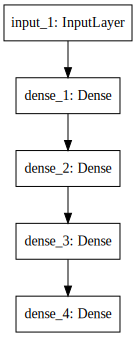

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Treinando nossa rede

In [7]:
epochs = 30
batch_size = 128

In [8]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 71s 1ms/step - loss: 0.2551 - val_loss: 0.2219
Epoch 2/30
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2150 - val_loss: 0.2084
Epoch 3/30
60000/60000 [==============================] - 67s 1ms/step - loss: 0.2052 - val_loss: 0.2028
Epoch 4/30
60000/60000 [==============================] - 68s 1ms/step - loss: 0.2010 - val_loss: 0.1998
Epoch 5/30
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1983 - val_loss: 0.1972
Epoch 6/30
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1962 - val_loss: 0.1954
Epoch 7/30
60000/60000 [==============================] - 60s 993us/step - loss: 0.1944 - val_loss: 0.1938
Epoch 8/30
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1930 - val_loss: 0.1925
Epoch 9/30
60000/60000 [==============================] - 60s 1ms/step - loss: 0.1917 - val_loss: 0.1915
Epo

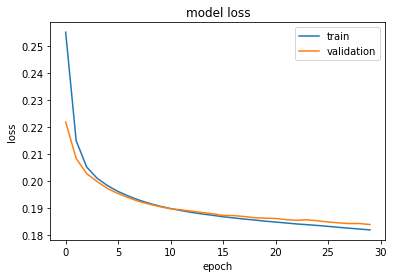

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Plotando nossa representação latente em 2D

In [10]:
encoder = Model(x, h)

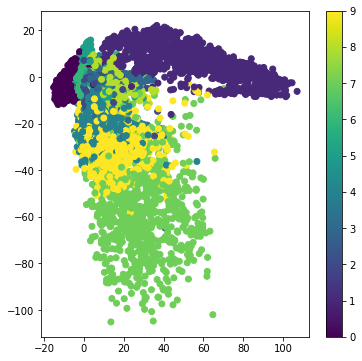

In [11]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

___

# **Autoencoder Variacional**

In [12]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

In [13]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [15]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [16]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [17]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss = vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

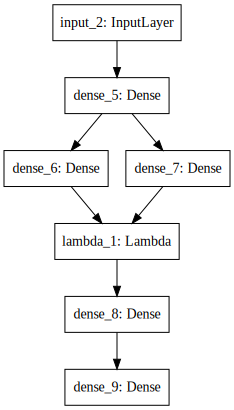

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [19]:
history = vae.fit(X_train, X_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 107s 2ms/step - loss: 194.8730 - val_loss: 174.6757
Epoch 2/30
60000/60000 [==============================] - 106s 2ms/step - loss: 171.3823 - val_loss: 169.2332
Epoch 3/30
60000/60000 [==============================] - 107s 2ms/step - loss: 167.7184 - val_loss: 166.5421
Epoch 4/30
60000/60000 [==============================] - 106s 2ms/step - loss: 165.5446 - val_loss: 164.9581
Epoch 5/30
60000/60000 [==============================] - 106s 2ms/step - loss: 163.9781 - val_loss: 163.3674
Epoch 6/30
60000/60000 [==============================] - 105s 2ms/step - loss: 162.7767 - val_loss: 162.3139
Epoch 7/30
60000/60000 [==============================] - 105s 2ms/step - loss: 161.7401 - val_loss: 161.6482
Epoch 8/30
60000/60000 [==============================] - 95s 2ms/step - loss: 160.7551 - val_loss: 161.0077
Epoch 9/30
60000/60000 [==============================] - 3637s 61ms/st

## Plotando as perdas

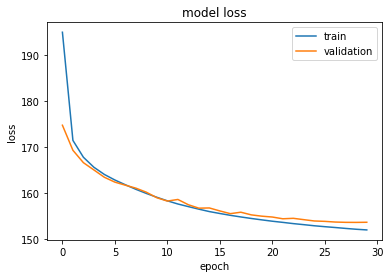

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Plotando a representação latente em 2D

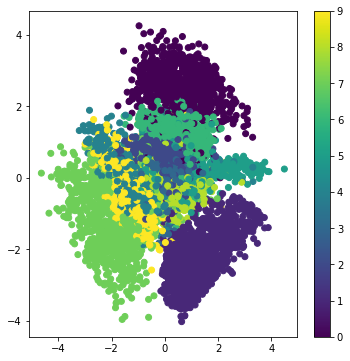

In [21]:
# construindo um modelo para projetar entradas no espaço latente
encoder = Model(x, z_mean)


# exibindo um gráfico 2D das classes de dígitos no espaço latente
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [22]:
# construir um gerador de dígitos que possa amostrar a partir da distribuição aprendida
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

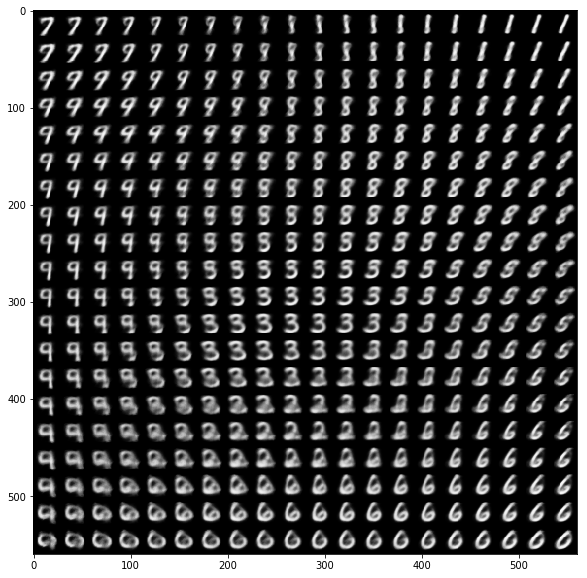

In [23]:
# exibindo uma representação (manifold) 2D dos dígitos
n = 20  # figura com dígitos 15x15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))


# coordenadas espaçadas linearmente no quadrado unitário foram transformadas através do CDF (ppf) inverso da Gaussiana
# para produzir valores das variáveis latentes z, já que a priore o espaço latente é Gaussiano
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()